---
This code assumes we're working with the output of a d2v model, but would work just fine with the echonest features. I just can't do that now because the common keys across the gracenote genre data and the echonest song IDs aren't ready yet. Once you have that this should be trivial to modify to work with echonest features.

---

In [6]:
from __future__ import print_function
import numpy as np
import pandas as pd
import gzip,os,glob
from scipy.misc import imread
from tqdm import tqdm_notebook as tq
from IPython.core.display import HTML, display
from matplotlib import pyplot as plt
%matplotlib inline
# this is a neat trick to make the notebook use the full width of the window
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# parameter and directory setup
colors =['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
genre_data_dir = 'P:/Projects/BigMusic/jared.rawdata/'
# change this if you're using the echonest features
feature_dir = 'P:/Projects/BigMusic/D2V/200-20-100-0/'
# feature_dir = 'P:/Projects/BigMusic/echonest_features/

### Category data loading

In [14]:
# here we build a big dataframe with all the WoS category data and join with the index data

gn = pd.read_table(genre_data_dir+'gracenote_song_data',index_col='songID')
# load the song_indices from our model (or use indices from the echonest features)
indices = np.array([int(line.strip()) for line in open(glob.glob('{}song_indices*'.format(feature_dir))[0])])
# reindex the gracenote dataframe to match the index sequence
gn = gn.ix[indices]
gn.head()

,GNID,gn_artist,gn_song,album_year,origin1,origin2,origin3,genre1,genre2,genre3,era1,era2
songID,,,,,,,,,,,,
674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21003,5139881-0db5e462eb2d54cbe9661dd475f36526,radiohead,karma+police,1997.0,western europe,united kingdom,england,alternative & punk,brit rock,brit rock,1990's,NaN
17695,12845136-e6bf24f25cfd347b588da2660bd69af5,nirvana,smells+like+teen+spirit,1991.0,north america,united states,washington,alternative & punk,alternative,grunge,1980's,late 80's
1612,107048172-d6af019bce46c37f3fee9ea674e40cb9,muse,starlight,2006.0,western europe,united kingdom,england,alternative & punk,brit rock,brit rock,2000's,NaN
526,270540283-b030c82a5443eaecc4df1baea24398ea,oasis,wonderwall,1995.0,western europe,united kingdom,england,alternative & punk,brit pop,brit pop,1990's,mid 90's


###  Datashader setup

In [18]:
# specify the background color and image size
plot_width  = int(900)
plot_height = int(900)
background = "black"

# some datashader-specific imports and custom functions adapted from this tutorial:
# https://www.continuum.io/blog/developer-blog/analyzing-and-visualizing-big-data-interactively-your-laptop-datashading-2010-us
from functools import partial
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

In [20]:
# Here we'll print out the possible lv_coord files to load
options = [f for f in os.listdir(feature_dir) if 'lv_coords' in f]
print(options)

# change this line (based on `options`) to choose which coordinates file you want to use
coords_file = 'model_200-20-100-0.wv.syn0.npy.None.lv_coords'

['model_200-20-100-0.wv.syn0.npy.None.lv_coords']


In [21]:
# load the coords file into a dataframe (skipping the first metadata row)
data = pd.read_table('{}{}'.format(feature_dir,coords_file),names=['x','y'],sep=' ',skiprows=1)

### Plotting with no metadata

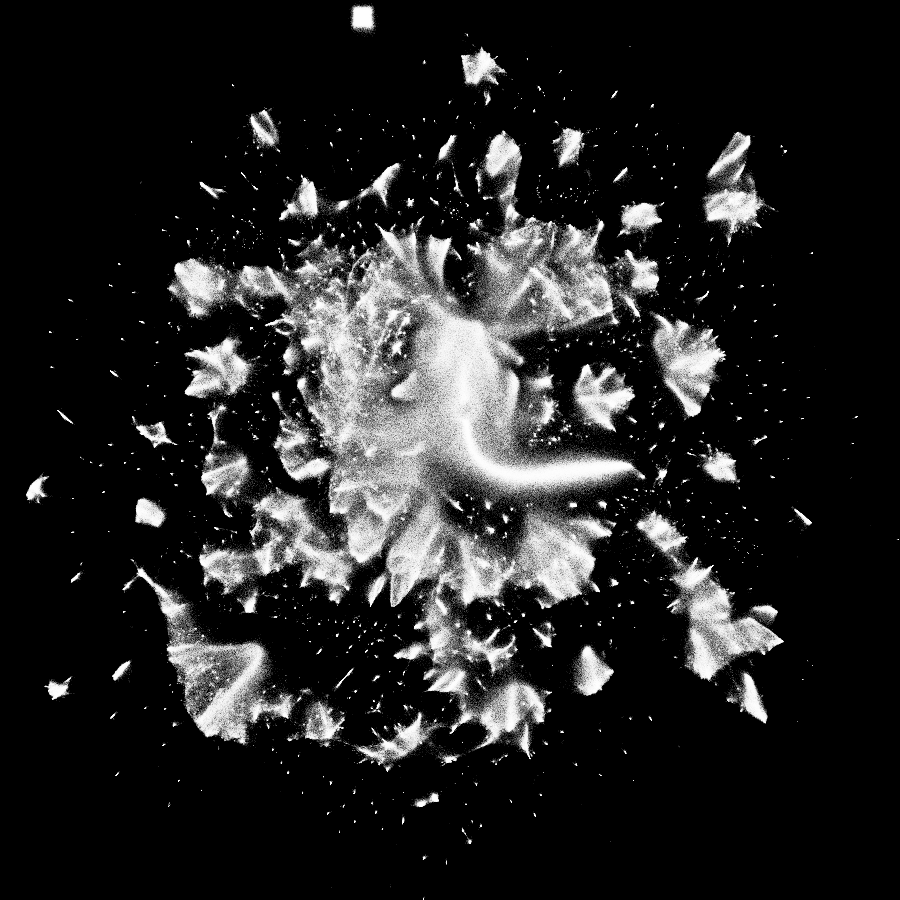

In [22]:
# this will just plot the raw coordinate data (each point is a song)
# note that canvas also accepts and x_range and y_range argument if you want to adjust that
cvs = ds.Canvas(plot_width,plot_height)
agg = cvs.points(data, 'x', 'y')
export(tf.shade(agg, cmap = cm(Greys9), how='eq_hist'),"tempfile")


In [30]:
gn.head()

,GNID,gn_artist,gn_song,album_year,origin1,origin2,origin3,genre1,genre2,genre3,era1,era2
songID,,,,,,,,,,,,
674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21003,5139881-0db5e462eb2d54cbe9661dd475f36526,radiohead,karma+police,1997.0,western europe,united kingdom,england,alternative & punk,brit rock,brit rock,1990's,NaN
17695,12845136-e6bf24f25cfd347b588da2660bd69af5,nirvana,smells+like+teen+spirit,1991.0,north america,united states,washington,alternative & punk,alternative,grunge,1980's,late 80's
1612,107048172-d6af019bce46c37f3fee9ea674e40cb9,muse,starlight,2006.0,western europe,united kingdom,england,alternative & punk,brit rock,brit rock,2000's,NaN
526,270540283-b030c82a5443eaecc4df1baea24398ea,oasis,wonderwall,1995.0,western europe,united kingdom,england,alternative & punk,brit pop,brit pop,1990's,mid 90's


### Coloring by genre label

In [31]:
# now we join the coordinate data with the category dataframe
# (we know the indexes are already set up, so we ignore that in the merge)
plot_data = pd.concat([gn.reset_index(drop=True),data],axis=1)
plot_data.head()

,GNID,gn_artist,gn_song,album_year,origin1,origin2,origin3,genre1,genre2,genre3,era1,era2,x,y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.373995,-1.726324
1,5139881-0db5e462eb2d54cbe9661dd475f36526,radiohead,karma+police,1997.0,western europe,united kingdom,england,alternative & punk,brit rock,brit rock,1990's,NaN,22.331562,2.164467
2,12845136-e6bf24f25cfd347b588da2660bd69af5,nirvana,smells+like+teen+spirit,1991.0,north america,united states,washington,alternative & punk,alternative,grunge,1980's,late 80's,15.539678,25.926556
3,107048172-d6af019bce46c37f3fee9ea674e40cb9,muse,starlight,2006.0,western europe,united kingdom,england,alternative & punk,brit rock,brit rock,2000's,NaN,-24.374159,-1.725656
4,270540283-b030c82a5443eaecc4df1baea24398ea,oasis,wonderwall,1995.0,western europe,united kingdom,england,alternative & punk,brit pop,brit pop,1990's,mid 90's,-15.196489,2.593263


In [32]:
# here I'm going to set the x range and y_range to just be the xy limits of the data, but you could modify this
xr = (plot_data.x.min(),plot_data.x.max())
yr = (plot_data.y.min(),plot_data.y.max())
xr,yr

((-35.002524999999999, 34.582684), (-34.409953999999999, 33.794585999999995))

In [27]:
# Now I'll define a custom plotting function that we'll use to generate our visuals
"""
To use this, we specify the following:
target_col (required,all other arguments optional) - this is the column specifying the genre level we want to color by
custom_colors - provide if you want to specify your own colors instead of the defaults
topN - only plot the topN most common unique values of target_col (this must be <= the number of colors in your color key, default 10)
limitcol/ limitval - before plotting, limit the data to songs for which limitcol = limitval
year - limit to songs released this year

This may seem confusing, so there are examples in the cells below
"""
def create_image(target_col,x_range=xr, y_range=yr, w=plot_width, h=plot_height,custom_colors=None,topN=None,limitcol=None,limitval=None,year=None):
    colors =['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
    
    if limitcol is not None:
        df = plot_data[plot_data[limitcol]==limitval]
    else:
        df = plot_data
    
    if topN is not None:
        topN = df[target_col].value_counts().dropna()[:topN].index.values
        df = df[df[target_col].isin(topN)]
    else:
        df = plot_data
    
    if year is not None:
        df = df[df.year==year]
    
    # drop any na values of the target column
    df = df.dropna(subset=[target_col])
        
    # large vis requires that this columns be categorical 
    df['plot_col'] = df[target_col].astype('category')
    
    unique_values = df['plot_col'].unique()
    if custom_colors is None:
        color_key = {val:color for val,color in zip(unique_values,colors)}  
    else:
        color_key = {val:color for val,color in zip(unique_values,custom_colors)} 
        
    # this generates the actual image, colored by category
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count_cat('plot_col'))
    img = tf.shade(agg, color_key=color_key, how='eq_hist')
    export(img,'temp')
    
    # to create a key, we must save the raster image, then load it into a matplotlib
    # figure, then draw the legend on that
    fig,ax = plt.subplots(1,1,figsize=(12,12))
    img = imread('export/temp.png')
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid()

    for cat in sorted(color_key.keys()):
        legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=25, label=cat, color=color_key[cat],lw=1)
    leg = ax.legend(loc='lower left',ncol=1,fontsize='large',framealpha=0)
    for t in leg.get_texts():
        t.set_color('white')
        
    del df['plot_col']



U:\Users\jjl2228\Anaconda\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


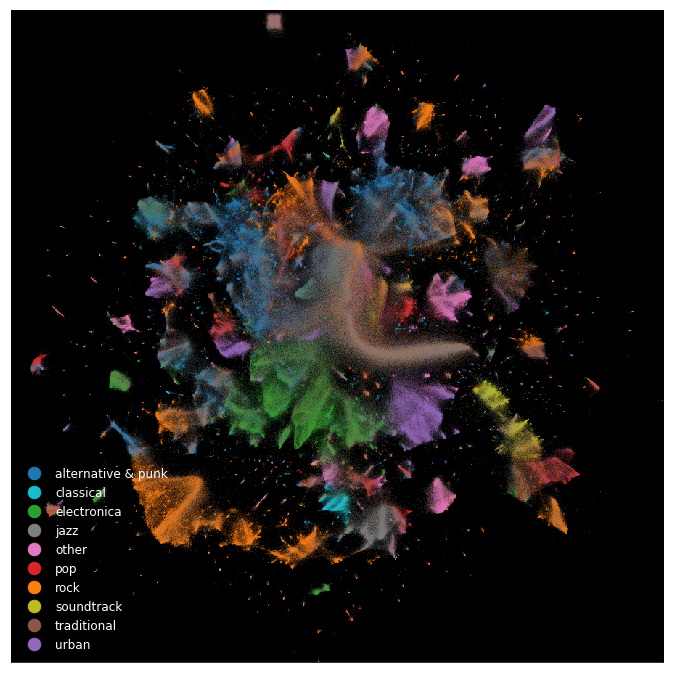

In [33]:
# example 1: plot all songs, colored by top-level genre
create_image('genre1')


U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:260: Run

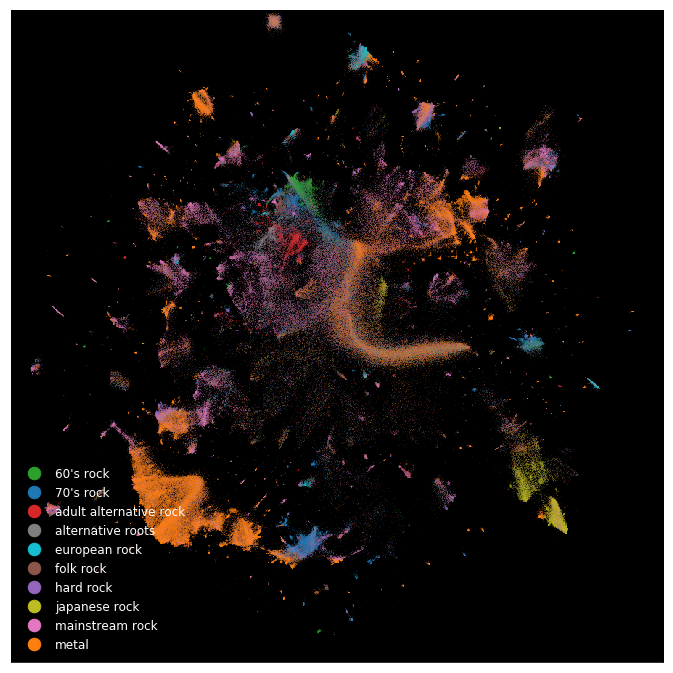

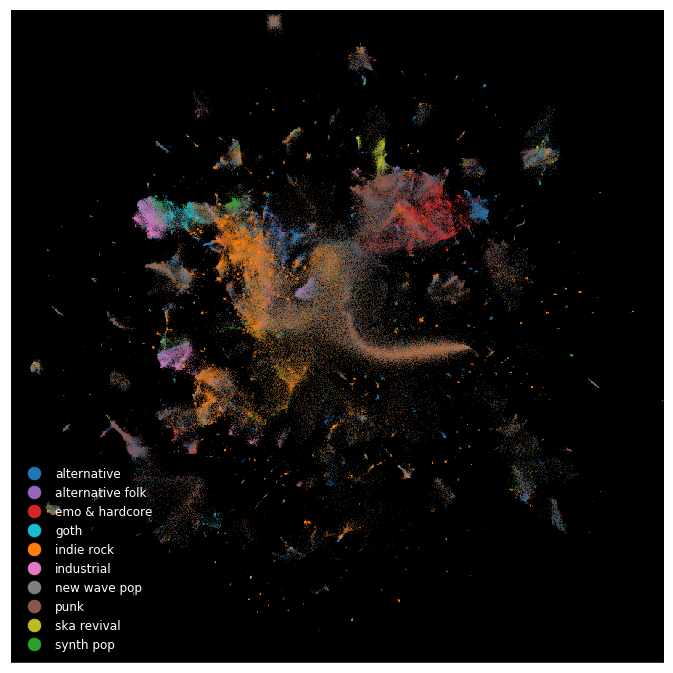

In [35]:
# To plot all subgenres of a given genre, we use the genre2 as teh target column, then set 
# the limitcol to genre1, and specify the genre for which we want the subgenre
# we use topN=10 to plot the top10 most common subgenres
create_image('genre2',topN=10,limitcol='genre1',limitval='rock')
create_image('genre2',topN=10,limitcol='genre1',limitval='alternative & punk')


U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
U:\Users\jjl2228\Anaconda\lib\site-packages\datashader\transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


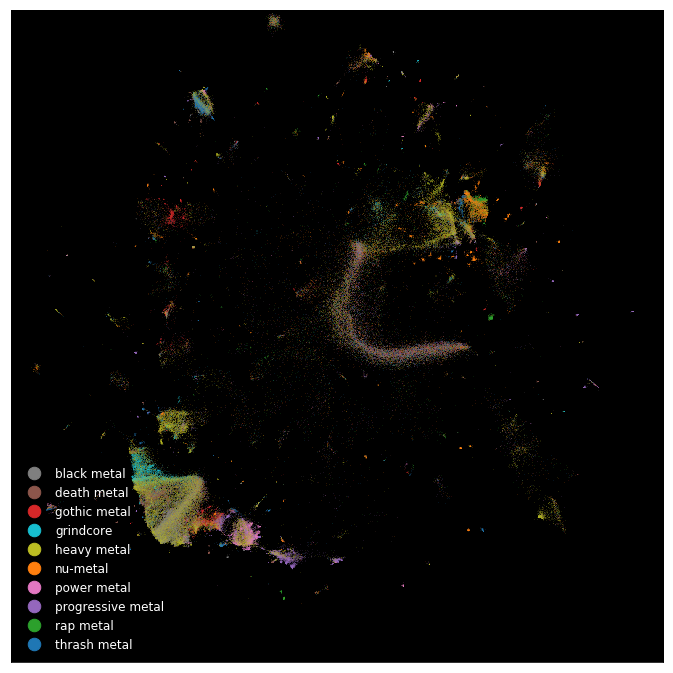

In [36]:
# Similarly, we can do sub-subgenres (though the visual gets pretty spars)
create_image('genre3',topN=10,limitcol='genre2',limitval='metal')
